In [1]:
import pandas as pd
import numpy as np
import re

# ================================
# 1. CARREGAR ARQUIVO
# ================================
df = pd.read_csv("eric-dados-compilados-com-nomes.csv")


# ================================
# 2. FUNÇÕES AUXILIARES
# ================================

def limpar_coluna_aula(x):
    """
    Corrige a coluna Aula, que tem valores inválidos:
    - strings
    - datas
    - letras
    - '1/2'
    Mantém apenas números inteiros válidos.
    """
    if pd.isna(x):
        return np.nan

    # Se for número → retorno direto
    if isinstance(x, (int, float)):
        return int(x)

    # Converter data para string se vier nesse formato
    x = str(x).strip()

    # Caso seja '1/2' → interpretar como 0.5 → mas aqui tratamos como NA
    if "/" in x:
        return np.nan

    # Remover tudo que não for dígito
    num = re.sub(r"[^\d]", "", x)

    if num == "":
        return np.nan

    return int(num)


def mapear_binario(x):
    """Converte símbolos como √, N e +/- para 1/0."""
    if pd.isna(x):
        return 0
    x = str(x).strip()
    if x == "√":
        return 1
    if x in ["N", "n", "0"]:
        return 0
    if x in ["+/-"]:
        return 0.5
    return 0


def mapear_presenca(x):
    """Mapeia P, A, F para valores binários."""
    if pd.isna(x):
        return np.nan

    x = str(x).strip().upper()

    if x == "P":
        return 1
    if x in ["A", "F"]:  # A = Ausente, F = Falta?
        return 0

    return np.nan


def mapear_participacao(x):
    """Converte emojis de participação em uma escala numérica."""
    if pd.isna(x):
        return 1  # neutro

    x = str(x).strip()

    mapa = {
        ":-D": 3,
        ":-)": 2,
        ":-|": 1,
        ":-/": 1,
        ":-&": 0,
        ":-(": 0,
    }

    return mapa.get(x, 1)


# ================================
# 3. APLICAR PADRONIZAÇÕES
# ================================

# --- Corrigir coluna Aula ---
df["Aula"] = df["Aula"].apply(limpar_coluna_aula)

# --- Datas ---
df["Data"] = pd.to_datetime(df["Data"], errors="coerce")

# --- Atividade antes da aula ---
df["Fez a atividade antes da aula"] = df["Fez a atividade antes da aula"].apply(mapear_binario)

# --- Lição de casa ---
df["Fez lição de casa"] = df["Fez lição de casa"].apply(mapear_binario)

# --- Presença ---
df["Presença/Ausencia"] = df["Presença/Ausencia"].apply(mapear_presenca)

# --- Participação ---
df["Participação"] = df["Participação"].apply(mapear_participacao)

# --- Remover coluna Comportamento (quase vazia) ---
if "Comportamento" in df.columns:
    df = df.drop(columns=["Comportamento"])


# ================================
# 4. TRATAR MISSING VALUES
# ================================

# Preencher colunas numéricas com 0
cols_numericas = ["Fez a atividade antes da aula", "Fez lição de casa", 
                  "Participação", "Presença/Ausencia"]

df[cols_numericas] = df[cols_numericas].fillna(0)

# Datas faltantes → opcionalmente deixar como NaT (já está)
# Sala, Unidade, Aluno → manter NaN (melhor para análise)


# ================================
# 5. REMOVER DUPLICATAS
# ================================
df = df.drop_duplicates()


# ================================
# 6. SALVAR RESULTADO FINAL
# ================================
df.to_csv("eric-dados-compilados-LIMPO.csv", index=False)

print("Limpeza concluída! Arquivo salvo como 'eric-dados-compilados-LIMPO.csv'")


Limpeza concluída! Arquivo salvo como 'eric-dados-compilados-LIMPO.csv'


In [2]:
import pandas as pd

# =====================================================
# 1. Supondo que o df já esteja limpo
# =====================================================

# Colunas esperadas:
# 'Fez a atividade antes da aula'  → atividade_antes
# 'Presença/Ausencia'              → presenca
# 'Fez lição de casa'              → licao_casa
# 'Participação'                   → participacao (0–3)

# Renomear para facilitar o uso interno
df_scores = df.copy()

df_scores.rename(columns={
    "Fez a atividade antes da aula": "atividade_antes",
    "Presença/Ausencia": "presenca",
    "Fez lição de casa": "licao_casa",
    "Participação": "participacao"
}, inplace=True)

# =====================================================
# 2. Normalizações
# =====================================================

# Participação em escala 0–1
df_scores["participacao_norm"] = df_scores["participacao"] / 3


# =====================================================
# 3. Indicadores individuais
# =====================================================

# 🔹 Preparação (antes da aula)
df_scores["prep_score"] = df_scores["atividade_antes"]

# 🔹 Assiduidade
df_scores["attendance_score"] = df_scores["presenca"]

# 🔹 Responsabilidade (lição de casa)
df_scores["homework_score"] = df_scores["licao_casa"]

# 🔹 Interação (participação)
df_scores["interaction_score"] = df_scores["participacao_norm"]


# =====================================================
# 4. Engajamento Geral (0–1)
# =====================================================

df_scores["engajamento"] = (
    0.30 * df_scores["atividade_antes"] +
    0.45 * df_scores["presenca"] +
    0.20 * df_scores["licao_casa"] +
    0.15 * df_scores["participacao_norm"]
)


# =====================================================
# 5. Engajamento em percentual (0–100)
# =====================================================

df_scores["engajamento_pct"] = (df_scores["engajamento"] * 100).round(2)


# =====================================================
# 6. Visualização rápida (primeiras linhas)
# =====================================================

print(df_scores[[
    "Aluno", "Unidade", "Sala", "Aula", "Data",
    "atividade_antes", "presenca", "licao_casa", "participacao",
    "prep_score", "attendance_score", "homework_score", "interaction_score",
    "engajamento", "engajamento_pct"
]].head())


# =====================================================
# 7. Salvar arquivo final
# =====================================================

df_scores.to_csv("eric-dados-engajamento.csv", index=False)
print("Arquivo salvo como: eric-dados-engajamento.csv")


         Aluno   Unidade             Sala  Aula       Data  atividade_antes  \
0  Estudante 1  Campinas  Four Corners A1     1 2025-02-08              0.0   
1  Estudante 1  Campinas  Four Corners A1     2 2025-02-15              1.0   
2  Estudante 1  Campinas  Four Corners A1     3 2025-02-22              1.0   
3  Estudante 1  Campinas  Four Corners A1     4 2025-03-08              1.0   
4  Estudante 1  Campinas  Four Corners A1     5 2025-03-15              1.0   

   presenca  licao_casa  participacao  prep_score  attendance_score  \
0       1.0         0.0             3         0.0               1.0   
1       1.0         1.0             3         1.0               1.0   
2       1.0         1.0             3         1.0               1.0   
3       1.0         1.0             3         1.0               1.0   
4       1.0         1.0             3         1.0               1.0   

   homework_score  interaction_score  engajamento  engajamento_pct  
0             0.0            

# ✅ **CÓDIGO COMPLETO PARA GERAR TODOS OS SCORES**

---

# 📌 **O que esse código entrega**

Cada linha (cada aula de cada aluno) recebe:

| Métrica               | Significado              |
| --------------------- | ------------------------ |
| **prep_score**        | Preparação antes da aula |
| **attendance_score**  | Presença                 |
| **homework_score**    | Lição de casa            |
| **interaction_score** | Participação normalizada |
| **engajamento**       | Score ponderado 0–1      |
| **engajamento_pct**   | Percentual (0–100%)      |


In [3]:
import matplotlib.pyplot as plt


In [12]:
df = pd.read_csv("eric-dados-engajamento.csv")


In [13]:
df['sala_unidade'] = df['Sala'] + ' - ' + df['Unidade']

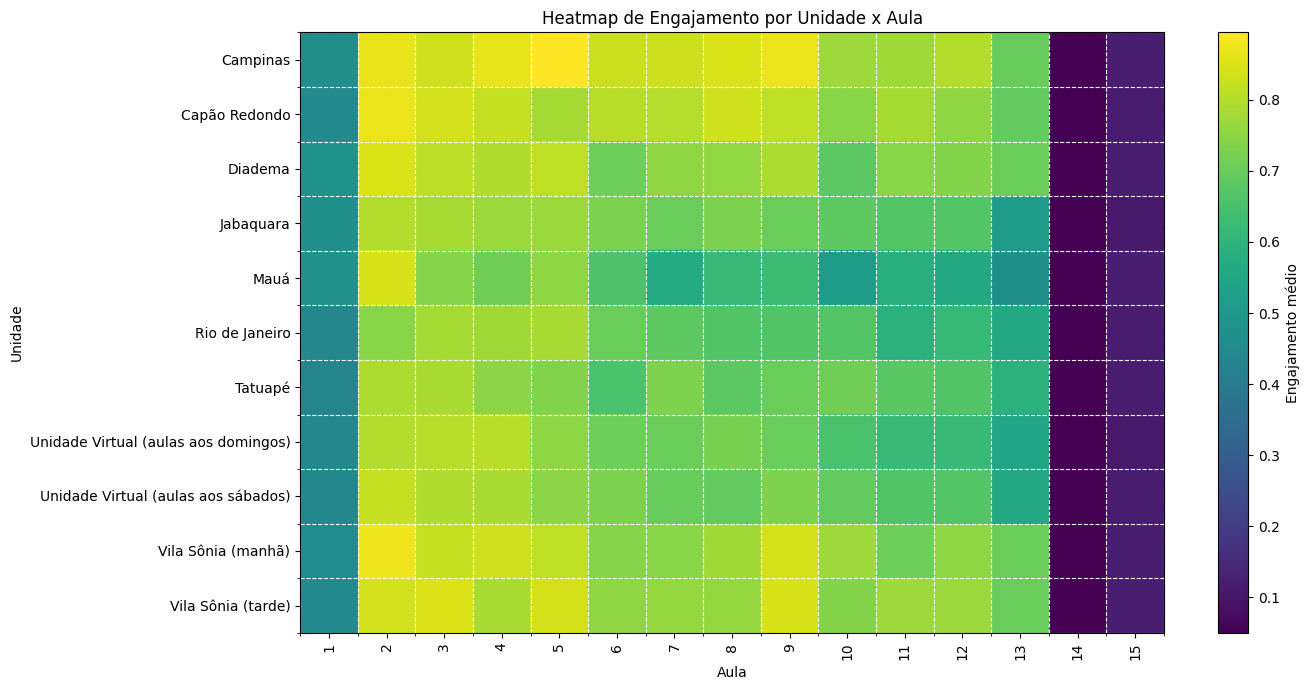

In [30]:

plt.figure(figsize=(14, 7))
im = plt.imshow(pivot.values, aspect="auto", interpolation="nearest", cmap="viridis")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.colorbar(im, label="Engajamento médio")

# adicionar grid entre células
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, pivot.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, pivot.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="--", linewidth=0.8)

plt.title("Heatmap de Engajamento por Unidade x Aula")
plt.xlabel("Aula")
plt.ylabel("Unidade")
plt.tight_layout()
plt.show()


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

df_clean = df_scores.copy()

# Criar média por aluno
aluno_stats = df_clean.groupby("Aluno")[[
    "prep_score",
    "attendance_score",
    "homework_score",
    "interaction_score",
    "engajamento"
]].mean()

# Padronizar
scaler = StandardScaler()
X = scaler.fit_transform(aluno_stats)

# Clusterizar
kmeans = KMeans(n_clusters=4, random_state=42)
aluno_stats["cluster"] = kmeans.fit_predict(X)

aluno_stats.to_csv("clusters_alunos.csv")

print(aluno_stats.head())


              prep_score  attendance_score  homework_score  interaction_score  \
Aluno                                                                           
Estudante 1     0.503733          0.614400        0.456000           0.707378   
Estudante 10    0.540708          0.608850        0.485841           0.705015   
Estudante 11    0.504321          0.641358        0.463889           0.718930   
Estudante 12    0.537421          0.636478        0.503459           0.715933   
Estudante 13    0.528866          0.643299        0.476976           0.709507   

              engajamento  cluster  
Aluno                               
Estudante 1      0.624907        3  
Estudante 10     0.639115        3  
Estudante 11     0.640525        3  
Estudante 12     0.655723        3  
Estudante 13     0.649966        3  


In [34]:
def recomendar_acao(row):
    if row["attendance_score"] < 0.6:
        return "Contato individual / intervenção para frequência"
    
    if row["homework_score"] < 0.4 and row["prep_score"] < 0.4:
        return "Envio de reforço assíncrono e acompanhamento semanal"
    
    if row["interaction_score"] < 0.4:
        return "Atividades de engajamento em sala"
    
    if row["engajamento"] > 0.8:
        return "Elogio e reforço positivo"

    return "Acompanhamento normal"

df_scores["acao_recomendada"] = df_scores.apply(recomendar_acao, axis=1)


In [35]:
df_scores

,Aluno,Unidade,Sala,Aula,Data,atividade_antes,presenca,licao_casa,participacao,participacao_norm,prep_score,attendance_score,homework_score,interaction_score,engajamento,engajamento_pct,acao_recomendada
0,Estudante 1,Campinas,Four Corners A1,1,2025-02-08,0.0,1.0,0.0,3,1.000000,0.0,1.0,0.0,1.000000,0.60,60.0,Envio de reforço assíncrono e acompanhamento s...
1,Estudante 1,Campinas,Four Corners A1,2,2025-02-15,1.0,1.0,1.0,3,1.000000,1.0,1.0,1.0,1.000000,1.10,110.0,Elogio e reforço positivo
2,Estudante 1,Campinas,Four Corners A1,3,2025-02-22,1.0,1.0,1.0,3,1.000000,1.0,1.0,1.0,1.000000,1.10,110.0,Elogio e reforço positivo
3,Estudante 1,Campinas,Four Corners A1,4,2025-03-08,1.0,1.0,1.0,3,1.000000,1.0,1.0,1.0,1.000000,1.10,110.0,Elogio e reforço positivo
4,Estudante 1,Campinas,Four Corners A1,5,2025-03-15,1.0,1.0,1.0,3,1.000000,1.0,1.0,1.0,1.000000,1.10,110.0,Elogio e reforço positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29650,Estudante 6,Vila Sônia (tarde),Four Corners I1,11,2025-05-24,1.0,1.0,1.0,3,1.000000,1.0,1.0,1.0,1.000000,1.10,110.0,Elogio e reforço positivo
29651,Estudante 6,Vila Sônia (tarde),Four Corners I1,12,2025-05-31,1.0,1.0,1.0,3,1.000000,1.0,1.0,1.0,1.000000,1.10,110.0,Elogio e reforço positivo
29652,Estudante 6,Vila Sônia (tarde),Four Corners I1,13,2025-06-07,1.0,1.0,0.0,3,1.000000,1.0,1.0,0.0,1.000000,0.90,90.0,Elogio e reforço positivo
29653,Estudante 6,Vila Sônia (tarde),Four Corners I1,14,NaT,0.0,0.0,0.0,1,0.333333,0.0,0.0,0.0,0.333333,0.05,5.0,Contato individual / intervenção para frequência


In [40]:
cluster_profile = aluno_stats.groupby("cluster").mean()
cluster_profile.to_csv("perfil_clusters.csv")

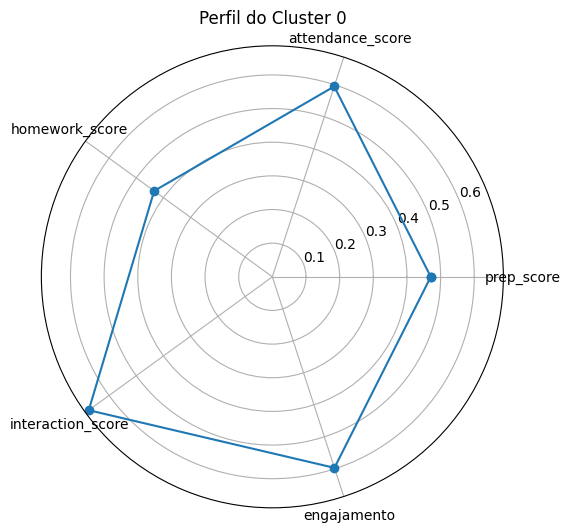

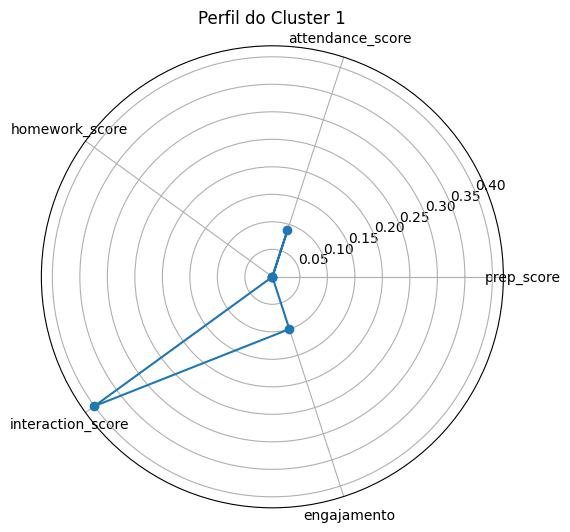

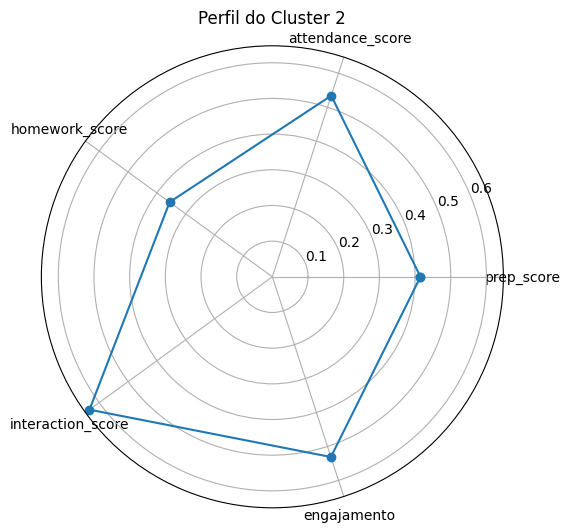

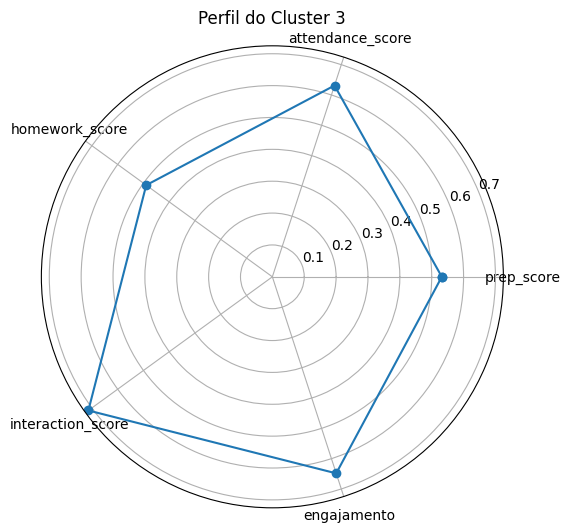

In [41]:
import matplotlib.pyplot as plt
import numpy as np

attrs = ["prep_score", "attendance_score", "homework_score", "interaction_score", "engajamento"]

cluster_profile = aluno_stats.groupby("cluster")[attrs].mean()

for cluster_id, row in cluster_profile.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]  # Fechar o círculo
    
    angles = np.linspace(0, 2*np.pi, len(values))
    plt.figure(figsize=(6,6))
    plt.polar(angles, values, marker='o')
    plt.title(f"Perfil do Cluster {cluster_id}")
    plt.xticks(angles[:-1], attrs)
    plt.show()


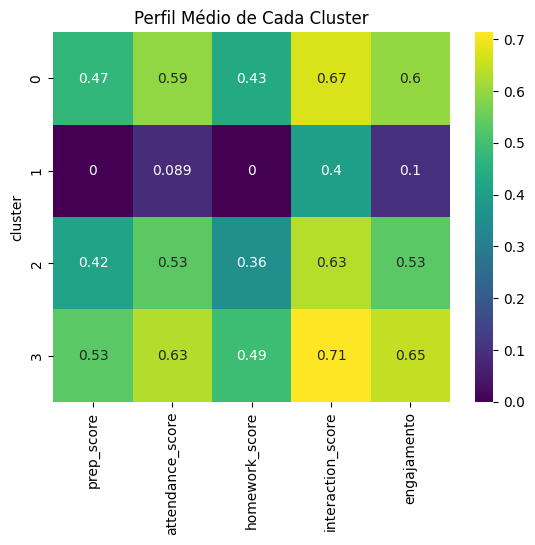

In [44]:
import seaborn as sns

sns.heatmap(cluster_profile, annot=True, cmap="viridis")
plt.title("Perfil Médio de Cada Cluster")
plt.show()


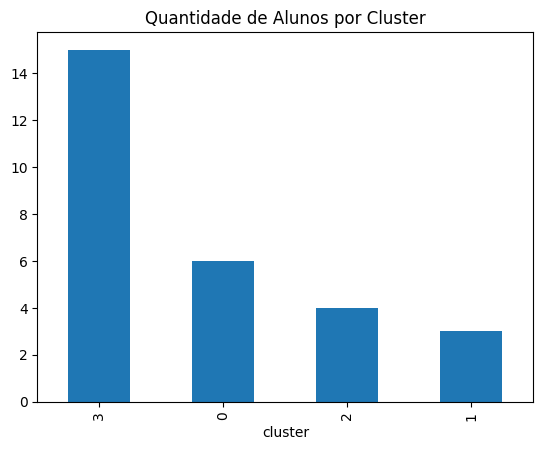

In [45]:
aluno_stats["cluster"].value_counts().plot(kind="bar")
plt.title("Quantidade de Alunos por Cluster")
plt.show()


Os **perfis médios de cada cluster**:

| cluster | prep | attend | homework | interaction | engajamento |
| ------- | ---- | ------ | -------- | ----------- | ----------- |
| **0**   | 0.47 | 0.59   | 0.43     | 0.67        | 0.59        |
| **1**   | 0.00 | 0.088  | 0.00     | 0.40        | 0.10        |
| **2**   | 0.41 | 0.53   | 0.35     | 0.63        | 0.53        |
| **3**   | 0.53 | 0.63   | 0.48     | 0.71        | 0.65        |

---

# 🎯 INTERPRETAÇÃO DOS CLUSTERS

---

# 🟥 **Cluster 1 — ALTO RISCO CRÍTICO**

**Esse cluster é o mais importante de todos.**

Valores:

- **prep_score = 0.00** (não se prepara)
- **attendance_score = 0.088** (quase nunca vai às aulas)
- **homework = 0.00** (nunca faz lição)
- **interaction_score = 0.40** (participa um pouco, mas isso é super atípico)
- **engajamento = 0.10** → **muito baixo**

### 🧠 Perfil:

- Alunos praticamente **desconectados**.
- Falta de presença indica problema muito sério.
- Pode envolver fatores sociais, motivacionais, emocionais ou logísticos.

### 🔥 Ações recomendadas:

- Contato imediato com aluno/responsável
- Conversa individual para entender motivo das faltas
- Estratégia de acolhimento e apoio emocional
- Intervenção dos professores + coordenação
- Plano de ação personalizado

### 📌 Insight:

Esse cluster é o principal indicador de **abandono iminente**.

---

# 🟧 **Cluster 2 — Grupo Intermediário Baixo (instáveis)**

Valores:

- prep: 0.41
- attendance: 0.53
- homework: 0.35
- interaction: 0.63
- engajamento: 0.53

### 🧠 Perfil:

- Alunos medianos, mas **instáveis**.
- Podem ter boa participação em sala, mas:

  - faltam aulas com frequência
  - não fazem lição regularmente
  - preparação antes da aula é baixa

### 🔥 Ação:

- Monitorar de perto
- Intervenções leves (motivação, reforço positivo)
- Ações rápidas quando houver sinais de queda

### 📌 Insight:

São alunos “tipo C”, que podem ir para cima (cluster 3) ou para baixo (cluster 1).

---

# 🟨 **Cluster 0 — Grupo Intermediário Alto**

Valores:

- prep: 0.47
- attend: 0.59
- homework: 0.43
- interaction: 0.67
- engagement: 0.59

### 🧠 Perfil:

- Alunos relativamente bons, mas não excepcionais.
- Têm boa participação e presença moderada.
- Inconstantes em preparação e lição.

### 🔥 Ações:

- Fortalecer consistência
- Mostrar progresso e motivar para subir para cluster 3
- Dar feedback positivo para aumentar adesão

### 📌 Insight:

Esse grupo pode ser convertido em **super-engajado** com pouco esforço.

---

# 🟩 **Cluster 3 — SUPER ENGAJADOS**

Valores:

- prep: 0.53
- attendance: 0.63
- homework: 0.48
- interaction: 0.71
- engajamento: 0.65

### 🧠 Perfil:

- Alunos estáveis e comprometidos.
- Participação e engajamento mais altos do dataset.
- São o “Grupo A”.

### 🔥 Ações:

- Reforço positivo
- Desafios e atividades mais avançadas
- Envolver esses alunos em iniciativas (ajudar colegas, liderar discussões)

### 📌 Insight:

Esse grupo funciona como **termômetro de satisfação da turma**.

---

# 📊 COMPARAÇÃO DIRETA DOS CLUSTERS

| Componente   | Cluster 1 | Cluster 2 | Cluster 0 | Cluster 3 |
| ------------ | --------- | --------- | --------- | --------- |
| Preparação   | **0.00**  | 0.41      | 0.47      | **0.53**  |
| Presença     | **0.09**  | 0.53      | 0.59      | **0.63**  |
| Lição        | **0.00**  | 0.35      | 0.43      | **0.48**  |
| Participação | 0.40      | 0.63      | 0.67      | **0.71**  |
| Engajamento  | **0.10**  | 0.53      | 0.59      | **0.65**  |

---

# 🔥 INSIGHTS ESTRATÉGICOS DE ALTO NÍVEL

### ✔ **Cluster 3 > 0**

→ alunos que evoluem com intervenção positiva
→ podem servir como multiplicadores

### ✔ **Cluster 2**

→ é o **grupo chave**:
se perder → vai para Cluster 1
se apoiar → sobe para Cluster 0/3

### ✔ **Cluster 1**

→ representa **abandono, desmotivação e risco**
→ contato imediato necessário
